In [ ]:

#-- Descomprimimos el dataset

!unzip mnist.zip

In [3]:
#--- Buscamos las direcciones de cada archivo de imagen
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

train_files[0]

'./mnist/train/1/6783.png'

In [4]:
#--- Ordenamos los datos de forma aleatoria para evitar sesgos
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(6000, 2000, 992)

In [5]:
#--- Cargamos los datos de entrenamiento en listas
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [6]:
#--- Cargamos los datos de validación en listas
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

In [7]:
#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

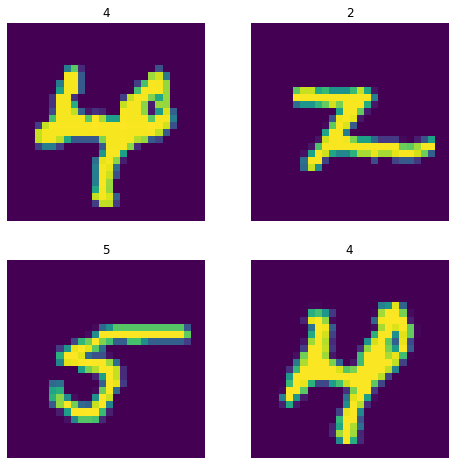

In [8]:
#-- Visualizamos los datos
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [9]:
#--- Convetimos las listas con los datos a tensores de torch
import torch
from torch.autograd import Variable


X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([6000, 28, 28])

In [10]:
from sklearn.metrics import confusion_matrix

def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()

In [11]:
from sklearn.metrics import f1_score

def train_valid(model, n_epoch, optimizer, criterion):
  loss_train = []
  f1_train = []
  acc_train = []

  loss_valid = []
  f1_valid = []
  acc_valid = []

  for epoch in range(n_epoch):
    model.train()

    Xtr = X_train.view(X_train.size(0), -1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train)
    loss_train.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
    
    acc = sum(Y_train == Y_pred)/len(Y_pred)
    acc_train.append(acc)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())

    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

  print( 'Valid Evaluation loss: {}. f1:{} acc: {} '.format(loss_valid[-1], f1_valid[-1], acc_valid[-1]) )
  CM(Y_valid, Y_pred, 10)
  values=[]
  f1_val=[]
  f1_val.append(f1_valid[-1])
  values.append([loss_valid[-1], f1_valid[-1], acc_valid[-1]])
  best=f1_val, values
  return best

Modelo 1


In [12]:
meta_para_1=[]
eval_1=[]
f1_1=[]

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm


bs_list = [256,512,1024]
lr_list = [0.001,0.01,0.1]
wd_list = [0.001,0.01,0.1]
hd_list = [50,80,100]
ne_list = [50,100,150]

pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(hd_list)*len(ne_list))

for ne in ne_list:
  for bs in bs_list:
    train_ds = TensorDataset(X_train, Y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    for lr in lr_list:
      for wd in wd_list:
        for hd in hd_list:
          input_dim = 28*28
          out_dim = 10
          hidden = hd

          model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden),
            torch.nn.ReLU(), 
            torch.nn.Linear(hidden, hidden),
            torch.nn.ReLU(),       
            torch.nn.Linear(hidden, out_dim)
          )

          optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
          criterion = torch.nn.CrossEntropyLoss()

          print('ne: {}, hd:{}, wd:{}, lr: {}, bs:{} '.format(ne,hd,wd,lr,bs))
          a=train_valid(model,ne,optimizer,criterion)
          a
          f1_1.append(a[0])
          eval_1.append(a[1])
          meta_para_1.append([ne,hd,wd,lr,bs])
          print('###################\n')
          

          pbar.update()
pbar.close()


In [14]:
max_index=np.argmax(f1_1)

print('ne: , hd:, wd:, lr: , bs: ')
print(meta_para_1[max_index])
print('#####')
print('Valid Evaluation loss: , f1:, acc:  ')
print(eval_1[max_index])
print('#####')
print('f1:')
print(f1_1[max_index])


ne: , hd:, wd:, lr: , bs: 
[150, 100, 0.1, 0.001, 512]
#####
Valid Evaluation loss: , f1:, acc:  
[[0.22039777040481567, 0.9309046704729873, tensor(0.9310)]]
#####
f1:
[0.9309046704729873]


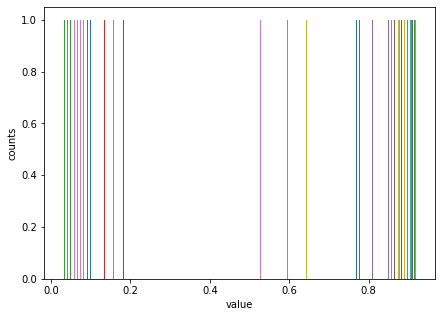

In [15]:
#--- Visualizando f_1
fig = plt.figure(figsize=(7,5))
plt.hist(f1_1)
plt.xlabel('value')
plt.ylabel('counts')
plt.show()

En este caso, el mejor modelo se obtubo a partir de utlizar los siguientes metaparametros

ne: 150 , hd:100 , wd: 0.1 , lr:0.001 , bs:512 










ne: 150, hd:100, wd:0.1, lr: 0.001, bs:512 
Valid Evaluation loss: 0.26247650384902954. f1:0.9166056732998017 acc: 0.9164999723434448 


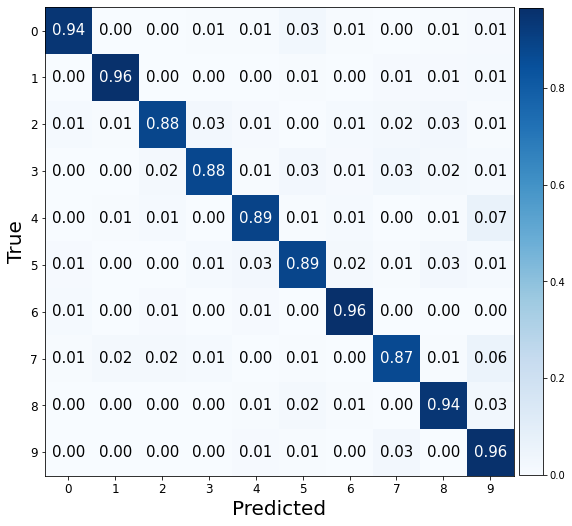

MEJOR MODELO


In [20]:

train_ds = TensorDataset(X_train, Y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

lr=0.001
ne=150
hd=100
wd=0.1
bs=512

input_dim = 28*28
out_dim = 10
hidden = hd

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(), 
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
criterion = torch.nn.CrossEntropyLoss()

print('ne: {}, hd:{}, wd:{}, lr: {}, bs:{} '.format(ne,hd,wd,lr,bs))
a=train_valid(model,ne,optimizer,criterion)
a


print('MEJOR MODELO')
      

    


**MODELO 2**

In [17]:
meta_para_2=[]
eval_2=[]
f1_2=[]

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm


bs_list = [256,512,1024]
lr_list = [0.001,0.01,0.1]
wd_list = [0.001,0.01,0.1]
hd_list = [50,80,100]
ne_list = [50,100,150]

pbar = tqdm(total=len(bs_list)*len(lr_list)*len(wd_list)*len(hd_list)*len(ne_list))

for ne in ne_list:
  for bs in bs_list:
    train_ds = TensorDataset(X_train, Y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    for lr in lr_list:
      for wd in wd_list:
        for hd in hd_list:
          input_dim = 28*28
          out_dim = 10
          hidden = hd

          model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden),
            torch.nn.ReLU(),       
            torch.nn.Linear(hidden, out_dim)
          )

          optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
          criterion = torch.nn.CrossEntropyLoss()

          print('ne: {}, hd:{}, wd:{}, lr: {}, bs:{} '.format(ne,hd,wd,lr,bs))
          a=train_valid(model,ne,optimizer,criterion)
          a
          f1_2.append(a[0])
          eval_2.append(a[1])
          meta_para_2.append([ne,hd,wd,lr,bs])
          print('###################\n')
          

          pbar.update()
pbar.close()


In [21]:
max_index=np.argmax(f1_2)

print('ne: , hd:, wd:, lr: , bs: ')
print(meta_para_2[max_index])
print('#####')
print('Valid Evaluation loss: , f1:, acc:  ')
print(eval_2[max_index])
print('#####')
print('f1:')
print(f1_2[max_index])

ne: , hd:, wd:, lr: , bs: 
[100, 100, 0.001, 0.001, 512]
#####
Valid Evaluation loss: , f1:, acc:  
[[0.5968353748321533, 0.9039771412346479, tensor(0.9040)]]
#####
f1:
[0.9039771412346479]


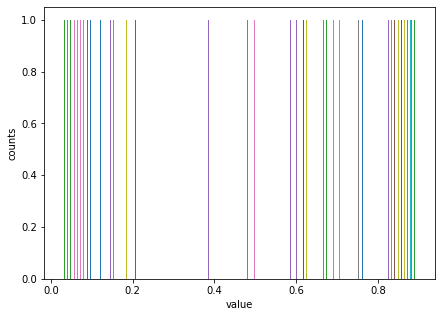

In [22]:
#--- Visualizando f_1
fig = plt.figure(figsize=(7,5))
plt.hist(f1_2)
plt.xlabel('value')
plt.ylabel('counts')
plt.show()

En este caso, el mejor modelo se obtubo a partir de utlizar los siguientes metaparametros

ne: 100 , hd:100 , wd: 0.1 , lr:0.001 , bs:512

ne: 100, hd:100, wd:0.1, lr: 0.001, bs:512 
Valid Evaluation loss: 0.28599390387535095. f1:0.9096751770107684 acc: 0.9100000262260437 


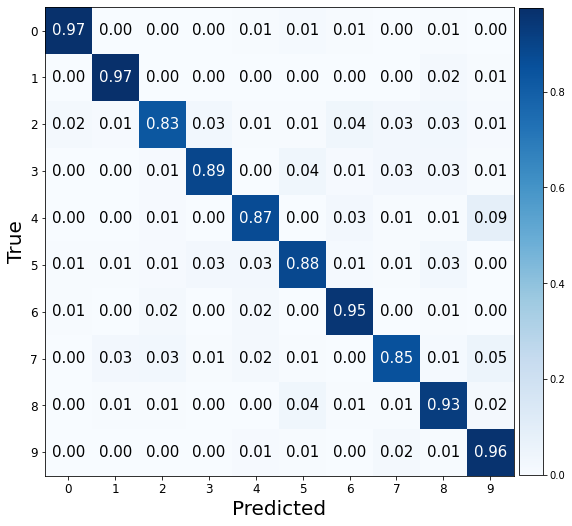

MEJOR MODELO


In [24]:
train_ds = TensorDataset(X_train, Y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

lr=0.001
ne=100
hd=100
wd=0.1
bs=512

input_dim = 28*28
out_dim = 10
hidden = hd

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(), 
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
criterion = torch.nn.CrossEntropyLoss()

print('ne: {}, hd:{}, wd:{}, lr: {}, bs:{} '.format(ne,hd,wd,lr,bs))
a=train_valid(model,ne,optimizer,criterion)
a


print('MEJOR MODELO')
      

    
